Facial Keypoints

In [ ]:
from sklearn.neighbors import NearestCentroid
from matplotlib.patches import Rectangle

In [1]:
import pandas as pd

from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
scaler = preprocessing.StandardScaler()

from matplotlib import pyplot as plt

import math

import cv2
import numpy as np
import imutils
import dlib
from imutils import face_utils
from numpy import savetxt

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

Face Pose Esmitation - Black Box

In [121]:
attribute_means = pd.read_csv("attribute_means.csv")
attribute_means

,stimulus,trustworthy,attractive,dominant,smart,age,gender,weight,typical,happy,...,hispanic,islander,native,black,white,looks-like-you,gay,electable,godly,outdoors
0,1,43.673077,46.552632,79.771429,55.405405,50.404255,86.891892,38.119048,66.736842,18.970588,...,18.828571,12.470588,13.925926,5.105263,92.970588,31.428571,20.523810,61.486486,53.439024,83.925000
1,2,65.000000,59.750000,48.666667,57.891892,31.300000,12.560976,48.275000,49.209302,75.771429,...,70.325000,63.236842,54.564516,72.735294,4.880952,13.465116,31.414634,66.184211,62.809524,57.513514
2,3,37.010526,36.000000,65.428571,65.057143,51.745098,74.789474,44.790698,48.666667,23.135135,...,44.375000,27.108108,33.898305,3.972222,68.787879,18.363636,46.024390,70.804878,55.921053,11.292683
3,4,64.053191,65.500000,47.194444,54.700000,24.777778,9.526316,32.375000,44.024390,59.526316,...,61.666667,60.352941,49.824561,72.552632,3.315789,10.500000,20.365854,57.179487,62.051282,16.560976
4,5,69.577320,50.702703,56.257143,61.527778,44.534884,14.650000,40.250000,70.184211,82.600000,...,14.162162,15.121212,10.910714,3.702703,88.842105,19.000000,21.783784,70.888889,71.833333,20.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,1000,51.678161,45.970588,59.171429,51.925000,40.142857,86.257143,53.235294,73.714286,53.647059,...,44.146341,15.228571,19.256410,6.647059,81.857143,26.371429,29.055556,57.975000,60.757576,14.923077
1000,1001,76.918605,66.928571,37.105263,53.864865,16.294118,11.200000,44.138889,57.228571,76.714286,...,51.600000,57.738095,45.717949,10.289474,58.500000,23.085714,18.783784,27.243902,68.800000,87.636364
1001,1002,50.318182,44.902439,63.578947,64.736842,37.969697,82.297297,51.333333,52.891892,34.450000,...,58.121212,77.078947,60.200000,18.500000,13.351351,16.515152,24.378378,63.871795,49.900000,12.914286
1002,1003,55.551724,69.842105,54.625000,48.250000,26.029412,8.307692,41.358974,54.085714,41.538462,...,68.000000,51.944444,44.375000,11.685714,47.027027,22.230769,25.400000,56.852941,63.435897,17.714286


In [5]:
def draw_annotation_box(img, rotation_vector, translation_vector, camera_matrix, color=(255, 255, 0), line_width=2):
    """Draw a 3D box as annotation of pose"""
    point_3d = []
    dist_coeffs = np.zeros((4, 1))
    rear_size = 1
    rear_depth = 0
    point_3d.append((-rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, -rear_size, rear_depth))

    front_size = img.shape[1]
    front_depth = front_size * 2
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d.append((-front_size, front_size, front_depth))
    point_3d.append((front_size, front_size, front_depth))
    point_3d.append((front_size, -front_size, front_depth))
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d = np.array(point_3d, dtype=np.float64).reshape(-1, 3)
    
    # Map to 2d img points
    (point_2d, _) = cv2.projectPoints(point_3d,
                                      rotation_vector,
                                      translation_vector,
                                      camera_matrix,
                                      dist_coeffs)
    point_2d = np.int32(point_2d.reshape(-1, 2))

    # # Draw all the lines
    # cv2.polylines(img, [point_2d], True, color, line_width, cv2.LINE_AA)
    k = (point_2d[5] + point_2d[8]) // 2
    # cv2.line(img, tuple(point_2d[1]), tuple(
    #     point_2d[6]), color, line_width, cv2.LINE_AA)
    # cv2.line(img, tuple(point_2d[2]), tuple(
    #     point_2d[7]), color, line_width, cv2.LINE_AA)
    # cv2.line(img, tuple(point_2d[3]), tuple(
    #     point_2d[8]), color, line_width, cv2.LINE_AA)

    return (point_2d[2], k)

In [6]:
model_points = np.array([
    (0.0, 0.0, 0.0),  # Nose tip
    (0.0, -330.0, -65.0),  # Chin
    (-225.0, 170.0, -135.0),  # Left eye left corner
    (225.0, 170.0, -135.0),  # Right eye right corne
    (-150.0, -150.0, -125.0),  # Left Mouth corner
    (150.0, -150.0, -125.0)  # Right mouth corner
])

In [7]:
ang1_col = np.array([])
ang2_col = np.array([])
smile_col = np.array([])

In [8]:
for c in range(1,1005):
    img = cv2.imread(str(c) + '.jpg')
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    size = img.shape

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    size = img.shape
    # 3D model points.
    model_points = np.array([
        (0.0, 0.0, 0.0),  # Nose tip
        (0.0, -330.0, -65.0),  # Chin
        (-225.0, 170.0, -135.0),  # Left eye left corner
        (225.0, 170.0, -135.0),  # Right eye right corne
        (-150.0, -150.0, -125.0),  # Left Mouth corner
        (150.0, -150.0, -125.0)  # Right mouth corner
    ])

    # Camera internals
    focal_length = size[1]
    center = (size[1] / 2, size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    image_points = np.array([
        shape[33],  # Nose tip
        shape[8],  # Chin
        shape[36],  # Left eye left corner
        shape[45],  # Right eye right corne
        shape[48],  # Left Mouth corner
        shape[54]  # Right mouth corner
    ], dtype="double")
    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix,
                                                                  dist_coeffs, flags=cv2.SOLVEPNP_UPNP)

    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose

    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector,
                                                     translation_vector, camera_matrix, dist_coeffs)

    p1 = (int(image_points[0][0]), int(image_points[0][1]))
    p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    x1, x2 = draw_annotation_box(img, rotation_vector, translation_vector, camera_matrix)

    try:
        m = (p2[1] - p1[1]) / (p2[0] - p1[0])
        ang1 = math.degrees(math.atan(m))
    except:
        ang1 = 90
    try:
        if x1[0] == x2[0]:
            ang2 = 0
        else:
            m = (x2[1] - x1[1]) / (x2[0] - x1[0])
            ang2 = math.degrees(math.atan(-1 / m))
    except:
        ang2 = 90
    ang1_col = np.append(ang1_col, ang1)
    ang2_col = np.append(ang2_col, ang2)
    if (shape[48][1]+shape[54][1])/2 < shape[66][1]:
        smile_col = np.append(smile_col, 1)
    else:
        smile_col = np.append(smile_col, 0)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
print(p1, p2)
print(x1, x2)

# down pos, up neg
print(ang1)
# left pos, right neg
print(ang2)

fig, ax = plt.subplots()
ax.imshow(img, extent = [0, 500, 0, 500], cmap = 'gray', origin='lower')
ax.scatter(image_points[:,0], image_points[:,1], color = 'red')
ax.invert_yaxis()
plt.show()

In [ ]:
attribute_means['ang1'] = ang1_col
attribute_means['ang2'] = ang2_col
attribute_means['smile'] = smile_col

In [ ]:
# Load the df dataset
df_X = attribute_means[['ang2']]
df_X = scaler.fit_transform(df_X)
df_y = attribute_means['happy']

# Split the data into training/testing sets
df_X_train = df_X[:-20]
df_X_test = df_X[-20:]
# Split the targets into training/testing sets
df_y_train = df_y[:-20]
df_y_test = df_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(df_X_train, df_y_train)
# Make predictions using the testing set
df_y_pred = regr.predict(df_X_test)

# The intercept
print("Intercept: \n", regr.intercept_)
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(df_y_test, df_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(df_y_test, df_y_pred))

3D Angle Approximation

In [189]:
tilt_list = np.array([])
pan_list = np.array([])
swing_list = np.array([])

In [190]:
for c in range(1,1005):
    img = cv2.imread(str(c) + '.jpg')
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    fcx = shape[3,0] # corner x coordinate
    fcy = min(shape[17:26,1]) # corner y coordinate
    fw = shape[13,0]-shape[3,0] # rec width
    fl = max(shape[5,1],shape[12,1]) - min(shape[17:26,1]) # rec length
    # eyebrows +10?

    pcx = shape[31,0] # corner x coordinate
    pcy = shape[30,1] # corner y coordinate
    pw = shape[35,0]-shape[31,0] # rec width
    pl = np.average([shape[60,1],shape[64,1]]) - shape[30,1] # rec length

    rx, ry = np.mean(shape[36:42,0]), np.mean(shape[36:42,1])
    lx, ly = np.mean(shape[42:47,0]), np.mean(shape[42:47,1])
    eye_x = np.mean([rx, lx])
    eye_y = np.mean([ry, ly])
    ph_x = shape[33,0]
    ph_y = shape[33,1]

    d = fl / 2
    l = fw / 2
    s = pcy - (fcy + d)

    tilt = np.arctan(s/np.sqrt(d**2-s**2)) - np.arctan(s/l)
    tilt_list = np.append(tilt_list, np.degrees(tilt))

    x = abs(eye_x-ph_x)
    y = abs(eye_y-ph_y)
    pan = 2*(np.arctan(x/np.sqrt(x**2+y**2))) # assuming human nose 45 degrees
    if eye_x > ph_x: pan = -pan
    pan_list = np.append(pan_list, np.degrees(pan))

    swing = np.arctan((ly-ry)/(lx-rx))
    swing_list = np.append(swing_list, np.degrees(swing))

In [191]:
attribute_means['tilt'] = tilt_list
attribute_means['pan'] = pan_list
attribute_means['swing'] = swing_list

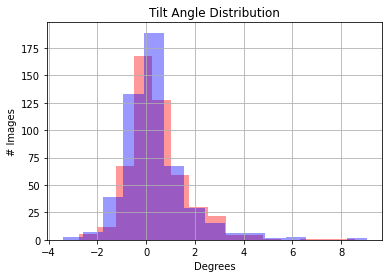

In [192]:
plt.figure()
attribute_means[attribute_means['happy']>59]['tilt'].hist(color='red',alpha=0.4, bins = 15)
attribute_means[attribute_means['happy']<59]['tilt'].hist(color='blue',alpha=0.4, bins = 15)
plt.title('Tilt Angle Distribution')
plt.xlabel('Degrees')
plt.ylabel('# Images')
plt.show()

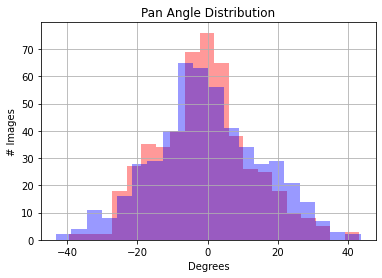

In [193]:
plt.figure()
attribute_means[attribute_means['happy']>59]['pan'].hist(color='red',alpha=0.4, bins = 20)
attribute_means[attribute_means['happy']<59]['pan'].hist(color='blue',alpha=0.4, bins = 20)
plt.title('Pan Angle Distribution')
plt.xlabel('Degrees')
plt.ylabel('# Images')
plt.show()

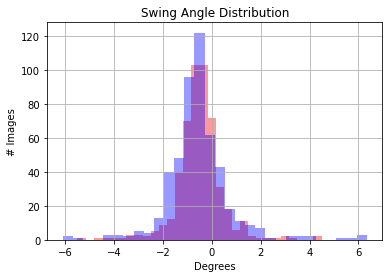

In [194]:
plt.figure()
attribute_means[attribute_means['happy']>59]['swing'].hist(color='red',alpha=0.4, bins = 30)
attribute_means[attribute_means['happy']<59]['swing'].hist(color='blue',alpha=0.4, bins = 30)
plt.title('Swing Angle Distribution')
plt.xlabel('Degrees')
plt.ylabel('# Images')
plt.show()

In [199]:
attribute_means[attribute_means['tilt']<-3]

,stimulus,trustworthy,attractive,dominant,smart,age,gender,weight,typical,happy,...,black,white,looks-like-you,gay,electable,godly,outdoors,tilt,pan,swing
32,33,82.132530,54.846154,20.189189,36.594595,2.022222,26.372093,46.575000,69.142857,54.810811,...,3.718750,95.861111,7.404762,15.500000,9.050000,60.463415,62.050000,-3.425021,-6.565474,-1.496024
133,134,38.903614,52.282051,76.085714,58.743590,44.605263,88.250000,51.351351,56.030303,22.828571,...,12.555556,62.163636,19.052632,28.159091,64.894737,50.717949,24.750000,-3.407790,0.046925,-0.365907
502,503,41.065217,41.804878,61.205882,57.030303,39.243902,85.971429,45.942857,62.611111,34.194444,...,1.641026,89.400000,21.218750,36.500000,52.139535,51.823529,71.885714,-3.090295,-1.875934,-0.673157


Tilt: 0.12246567258269744
Pan: 0.7287397686596954
Swing: 0.016277209651044507


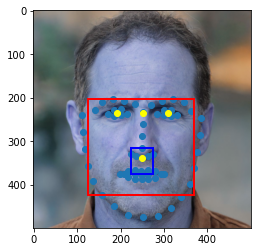

Tilt: 0.40213909237005024
Pan: 14.460379825289518
Swing: -2.508090745347464


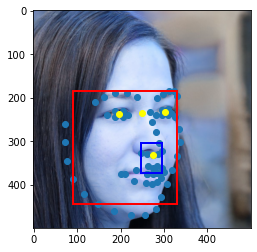

In [197]:
tiltg6 = [33, 134, 503]

for c in tiltg6:
    img = cv2.imread(str(c) + '.jpg')
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    fcx = shape[3,0] # corner x coordinate
    fcy = min(shape[17:26,1]) # corner y coordinate
    fw = shape[13,0]-shape[3,0] # rec width
    fl = max(shape[5,1],shape[12,1]) - min(shape[17:26,1]) # rec length
    # eyebrows +10?

    pcx = shape[31,0] # corner x coordinate
    pcy = shape[30,1] # corner y coordinate
    pw = shape[35,0]-shape[31,0] # rec width
    pl = np.average([shape[60,1],shape[64,1]]) - shape[30,1] # rec length

    rx, ry = np.mean(shape[36:42,0]), np.mean(shape[36:42,1])
    lx, ly = np.mean(shape[42:47,0]), np.mean(shape[42:47,1])
    eye_x = np.mean([rx, lx])
    eye_y = np.mean([ry, ly])
    ph_x = shape[33,0]
    ph_y = shape[33,1]

    d = fl / 2
    l = fw / 2
    s = pcy - (fcy + d)

    tilt = np.arctan(s/np.sqrt(d**2-s**2)) - np.arctan(s/l)
    x = abs(eye_x-ph_x)
    y = abs(eye_y-ph_y)
    pan = np.arctan(x/np.sqrt(x**2+y**2))
    swing = np.arctan((ly-ry)/(lx-rx))
    print('Tilt: '+str(np.degrees(tilt)))
    print('Pan: '+str(np.degrees(pan)))
    print('Swing: '+str(np.degrees(swing)))

    plt.imshow(img)
    plt.gca().add_patch(Rectangle((fcx, fcy),fw,fl,
                        edgecolor='red',
                        facecolor='none',
                        lw=2))
    plt.gca().add_patch(Rectangle((pcx, pcy),pw,pl,
                        edgecolor='blue',
                        facecolor='none',
                        lw=2))
    plt.scatter(shape[:,0],shape[:,1])
    plt.scatter(rx, ry, color = 'yellow')
    plt.scatter(lx, ly, color = 'yellow')
    plt.scatter(eye_x, eye_y, color = 'yellow')
    plt.scatter(ph_x, ph_y, color = 'yellow')
    plt.show()